In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated, Optional
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [3]:
from sqlalchemy import create_engine
import os
# Database connection details
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

# Create connection
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")


In [4]:
import pandas as pd
tables = pd.read_sql_query("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'", engine)
tables.to_json()

'{"table_name":{"0":"customers","1":"orders","2":"products","3":"sellers","4":"payments","5":"geolocation","6":"product_category_translation","7":"order_items"}}'

In [55]:
SCHEMA_INFO = """
Database Schema for E-commerce System:

1. customers
   - customer_id (TEXT): Unique customer identifier (Key for linking to orders)
   - customer_unique_id (TEXT): Unique customer identifier across datasets
   - customer_zip_code_prefix (INTEGER): Customer zip code
   - customer_city (TEXT): Customer city
   - customer_state (TEXT): Customer state

2. orders
   - order_id (TEXT): Unique order identifier
   - customer_id (TEXT): Foreign key to customers
   - order_status (TEXT): Order status (delivered, shipped, etc.)
   - order_purchase_timestamp (TEXT): Order date (stored as ISO string 'YYYY-MM-DD...'). Use SUBSTR(col,1,7) for monthly grouping.
   - order_approved_at (TEXT): When payment was approved
   - order_delivered_carrier_date (TEXT): When order was handed to carrier
   - order_delivered_customer_date (TEXT): When customer received the order
   - order_estimated_delivery_date (TEXT): Estimated delivery date

3. order_items
   - order_id (TEXT): Foreign key to orders
   - order_item_id (INTEGER): Item sequence number within order
   - product_id (TEXT): Foreign key to products
   - seller_id (TEXT): Foreign key to sellers
   - shipping_limit_date (TEXT): Shipping deadline
   - price (REAL): Item price
   - freight_value (REAL): Shipping cost

4. payments
   - order_id (TEXT): Foreign key to orders
   - payment_sequential (INTEGER): Payment sequence number
   - payment_type (TEXT): Payment method (credit_card, boleto, etc.)
   - payment_installments (INTEGER): Number of installments
   - payment_value (REAL): Payment amount

5. products
   - product_id (TEXT): Unique product identifier
   - product_category_name (TEXT): Product category (in Portuguese)
   - product_name_length (INTEGER): Product name length
   - product_description_length (INTEGER): Product description length
   - product_photos_qty (INTEGER): Number of product photos
   - product_weight_g (REAL): Product weight in grams
   - product_length_cm (REAL): Product length in cm
   - product_height_cm (REAL): Product height in cm
   - product_width_cm (REAL): Product width in cm

6. sellers
   - seller_id (TEXT): Unique seller identifier
   - seller_zip_code_prefix (INTEGER): Seller zip code
   - seller_city (TEXT): Seller city
   - seller_state (TEXT): Seller state

7. geolocation
   - geolocation_zip_code_prefix (INTEGER): Zip code prefix
   - geolocation_lat (REAL): Latitude
   - geolocation_lng (REAL): Longitude
   - geolocation_city (TEXT): City name
   - geolocation_state (TEXT): State code

8. product_category_translation
   - product_category_name (TEXT): Product category name in Portuguese
   - product_category_name_english (TEXT): English translation of category name
"""

In [56]:
class SQLState(TypedDict):
    text: str
    iteration: int
    query: Optional[str]
    query_result: Optional[str]
    error: Optional[str]
    final_answer: Optional[str]
    needs_graph: Optional[bool]
    graph_type: Optional[str]
    visualization: Optional[str]

### todo: 
- a single report can have multiple visualizations, as a query can generate a table with varied columns
- we can make visualizations from str to list, so that it can have multiple visualizations
- add loop

In [57]:
def text_to_sql(state: SQLState):
    """
    Convert a natural language query to SQL.
    """
    text = state["text"]
    prompt = f"""You are a SQL expert. Convert the following natural language question into a valid PostgreSQL query.
    
        Database Schema:
        {SCHEMA_INFO}

        Question: {text}

        Important Guidelines:
        1. Use only the tables and columns mentioned in the schema.
        2. Use proper JOIN clauses when querying multiple tables.
        3. Return ONLY the SQL query without any explanation or markdown formatting.
        4. If the question contains multiple sub-questions, generate separate SQL queries separated by semicolons.
        5. Use aggregate functions (COUNT, SUM, AVG, etc.) appropriately.
        6. Add LIMIT clauses for queries that might return many rows (default LIMIT 10 unless user specifies).
        7. Use proper WHERE clauses to filter data.
        
        CRITICAL DATE HANDLING RULES:
        8. The date columns (like 'order_purchase_timestamp') are stored as TEXT strings (Format: 'YYYY-MM-DD HH:MM:SS'). 
           - DO NOT use DATE_TRUNC or EXTRACT directly on them.
           - To group by Month: Use SUBSTR(column_name, 1, 7)  (Example: '2017-01')
           - To group by Year: Use SUBSTR(column_name, 1, 4)
           - If you MUST use date comparisons, cast them first: CAST(column_name AS TIMESTAMP).
        
        9. Each SQL statement should be on its own line.

        Generate the SQL query:
        """
    
    iteration = state["iteration"]
    response = model.invoke(prompt).content
    return {"query": response, "iteration": iteration + 1}

In [58]:
def execute_query(state: SQLState):
    try:
        query = state['query'].replace("```sql", "").replace("```", "").strip()
        df = pd.read_sql_query(query, engine)
        return {"query_result": df.to_json()}
    except Exception as e:
        return {"error": str(e)}

In [ ]:
def analyze_result(state: SQLState):
    result = state['query_result']
    question = state['text']
    visualization_path = state.get('visualization')
    
    instructions = """
    Analyze the result of the query and provide valuable insights for the user.
    Format your response in clear Markdown.
    """

    if visualization_path:
        instructions += f"""
        \nIMPORTANT: A visualization graph has been generated for this data. 
        It is located at this path: `{visualization_path}`
        
        You MUST include this graph in your response using standard Markdown image syntax:
        ![Graph of Analysis]({visualization_path})
        
        Place the graph in the response where it makes the most sense contextually (usually after the data summary).
        """

    prompt = f"""
        {instructions}
        
        Question: {question}
        Result: {result}
        
        Provide the final answer now:
    """

    # Get response from LLM
    response = model.invoke(prompt).content
    
    return {
        "final_answer": response
    }

In [60]:
def check_for_error(state):
    if state.get("error"):
        return "error"
    else:
        return "success"

In [61]:
def route_to_graph(state):
    if state.get("needs_graph"):
        return "generate"
    else:
        return "skip"

In [62]:
def error_solver(state: SQLState):
    error = state["error"]
    text = state["text"]
    query = state["query"]
    iteration = state["iteration"]
    
    if iteration > 3:
        error_msg = f"I apologize, but I'm having trouble generating a correct SQL query. Error: {error}"
        return {
            "final_answer": error_msg, 
            "iteration": iteration + 1
        }
    
    prompt = f"""
        The following SQL query failed with an error. Please fix it.
        {SCHEMA_INFO}
        Original Question: {text}
        Failed SQL Query: {query}
        Error: {error}
        Generate a corrected SQL query. Return ONLY the SQL query:
    """

    response = model.invoke(prompt).content
    
    return {
        "query": response,
        "error": None, # Reset error so the loop can try again
        "iteration": iteration + 1
    }

In [63]:
import json

def decide_graph_need(state: SQLState):
    
    question = state["text"]
    result = state["query_result"]
    
    # 1. Safety Check: If there was an error or empty result, skip graph
    if state.get("error") or not result or result == "{}":
        return {"needs_graph": False, "graph_type": "none"}

    # 2. The Prompt
    prompt = f"""
    You are a Data Visualization expert. Analyze the following Question and Data to determine if a visualization would add value.

    Question: {question}
    Data Sample (JSON): {str(result)[:1000]}... 

    Rules:
    - TIMELINES (dates) -> "line"
    - COMPARING CATEGORIES -> "bar"
    - PROPORTIONS/PERCENTAGES -> "pie"
    - CORRELATIONS (X vs Y) -> "scatter"
    - Single numbers or simple text lists -> "none"

    Return ONLY a valid JSON object with no extra text:
    {{
        "needs_graph": true/false,
        "graph_type": "bar/line/pie/scatter/none"
    }}
    """

    # 3. Invoke Model
    response = model.invoke(prompt).content
    
    # 4. Clean and Parse JSON
    try:
        # Use the cleaning trick to handle ```json wrappers
        cleaned_response = response.replace("```json", "").replace("```", "").strip()
        decision = json.loads(cleaned_response)
        
        return {
            "needs_graph": decision.get("needs_graph", False),
            "graph_type": decision.get("graph_type", "none")
        }
    except Exception:
        # Fallback default if LLM generates bad JSON
        return {"needs_graph": False, "graph_type": "none"}

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import uuid  # Standard library for unique IDs
import os

def generate_visualization(state: SQLState):
    """
    Generates a unique plot based on the state and saves it with a unique ID.
    """
    if not state.get("needs_graph"):
        return {"visualization": None}

    try:
        df = pd.read_json(state["query_result"])
    except Exception:
        return {"visualization": None}

    # --- PLOTTING LOGIC ---
    plt.figure(figsize=(10, 6))
    plt.clf() # Clear current figure to prevent overlapping data
    
    graph_type = state["graph_type"]
    
    try:
        x_col = df.columns[0] 
        y_col = df.select_dtypes(include=['number']).columns[0]
    except IndexError:
        return {"visualization": None}

    if graph_type == "bar":
        plt.bar(df[x_col].astype(str), df[y_col], color='skyblue')
        plt.xticks(rotation=45, ha='right')
    elif graph_type == "line":
        df = df.sort_values(by=x_col)
        plt.plot(df[x_col].astype(str), df[y_col], marker='o', color='green')
        plt.xticks(rotation=45, ha='right')
    elif graph_type == "pie":
        plt.pie(df[y_col], labels=df[x_col].astype(str), autopct='%1.1f%%')
    elif graph_type == "scatter":
        plt.scatter(df[x_col], df[y_col], alpha=0.5)

    plt.title(f"{y_col} by {x_col}")
    plt.tight_layout()
    
    # --- UNIQUE FILENAME LOGIC ---
    # Create a unique ID (e.g., 'viz_a1b2c3d4.png')
    unique_id = str(uuid.uuid4())[:8] 
    output_path = f"assets/viz_{unique_id}.png"
    
    plt.savefig(output_path)
    plt.close() # Close to free up memory
    
    return {"visualization": output_path}

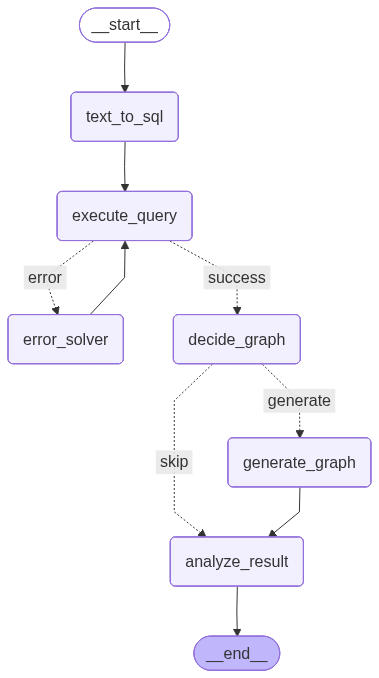

In [65]:
graph = StateGraph(SQLState)

graph.add_node("text_to_sql", text_to_sql)
graph.add_node("execute_query", execute_query)
graph.add_node("error_solver", error_solver)
graph.add_node("decide_graph", decide_graph_need)      # New Decision Node
graph.add_node("generate_graph", generate_visualization) # New Plotting Node
graph.add_node("analyze_result", analyze_result)

graph.add_edge(START, "text_to_sql")
graph.add_edge("text_to_sql", "execute_query")

# Error Handling Split
graph.add_conditional_edges(
    "execute_query",
    check_for_error,
    {
        "error": "error_solver",
        "success": "decide_graph"  # If successful, go to decision node
    }
)

# Graph Decision Split
graph.add_conditional_edges(
    "decide_graph",
    route_to_graph,
    {
        "generate": "generate_graph", # If yes, go to plotter
        "skip": "analyze_result"      # If no, skip to analysis
    }
)

# Rejoin Paths
graph.add_edge("generate_graph", "analyze_result")
graph.add_edge("error_solver", "execute_query")
graph.add_edge("analyze_result", END)

SQLAgent = graph.compile()
SQLAgent


In [66]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, Markdown

In [67]:
user_input = input("Enter your query(in plain english): ")

initial_state = {
    "text": user_input,
    "iteration": 0   
}

result = SQLAgent.invoke(initial_state)
text = result['text']
query = result['query']
query_result = pd.read_json(result['query_result'])
response_text = result['final_answer']


In [68]:

print("Your Input: ", user_input)
print("\nSQL Query: ", query)
print("\nResult: ", query_result)

# Display it rendered
display(Markdown(response_text))

Your Input:  Show me a trend of the total number of orders placed each month throughout the entire history of the dataset.

SQL Query:  ```sql
SELECT SUBSTR(CAST(order_purchase_timestamp AS TEXT), 1, 7) AS order_month, COUNT(order_id) AS total_orders
FROM orders
GROUP BY order_month
ORDER BY order_month;
```

Result:     order_month  total_orders
0      2016-09             4
1      2016-10           324
2      2016-12             1
3      2017-01           800
4      2017-02          1780
5      2017-03          2682
6      2017-04          2404
7      2017-05          3700
8      2017-06          3245
9      2017-07          4026
10     2017-08          4331
11     2017-09          4285
12     2017-10          4631
13     2017-11          7544
14     2017-12          5673
15     2018-01          7269
16     2018-02          6728
17     2018-03          7211
18     2018-04          6939
19     2018-05          6873
20     2018-06          6167
21     2018-07          6292
22     2018-0

The query asked for the trend of the total number of orders placed each month throughout the dataset's history. The result shows the total orders for each month, starting from September 2016 and going up to October 2018. Let's visualize this data to understand the trend better.

![Graph of Analysis](assets/viz_4351d89f.png)

The graph shows a clear trend in the number of orders per month.  Here are some key observations:

*   **Initial Growth:** From September 2016 to March 2017, there's a significant increase in the number of orders. This suggests that the business was gaining traction during this period.
*   **Mid-2017 Fluctuation:** From April 2017 to October 2017, the number of orders fluctuates, but remains relatively high compared to the initial months. This could be due to seasonal variations or specific marketing campaigns.
*   **Late 2017 Peak:** November 2017 shows a significant spike in order numbers, indicating a potential peak season, possibly driven by holiday sales or special promotions.
*   **Early 2018 Consistency:** The order volume remains high and relatively stable from January 2018 to August 2018, indicating a level of consistent performance.
*   **End of Data Drop:** September and October 2018 show a sharp drop in order numbers. This could be due to incomplete data for those months, a significant change in business operations, or the end of the dataset's recording period.

**Insights and Recommendations:**

*   **Seasonality:** Identify the factors that contributed to the peak in November 2017 and try to replicate them in subsequent years. Analyze if similar spikes occurred in other years as well.
*   **Marketing Campaign Effectiveness:** Correlate marketing campaigns with order volume to determine the effectiveness of different strategies.
*   **Data Completeness:** Investigate why the order numbers are so low for September and October 2018. Ensure that the data is complete for accurate analysis. If it's an anomaly, investigate the root cause.
*   **Further Analysis:** Investigate the reasons behind the fluctuations in order volume during mid-2017. Analyze customer behavior and external factors to understand the causes better.
*   **Forecasting:** Use this historical data to forecast future order volumes and plan resources accordingly.